In [2]:
# !pip install gurobipy

In [3]:
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
import networkx as nx
from skimage import color
from sklearn.feature_extraction import image
import math
import pandas as pd
from PIL import Image
from scipy.sparse import coo_matrix, save_npz, csr_matrix

In [4]:
# Function to load the intensity matrix from CSV or Image
def load_data(file_path):
    if file_path.endswith('.csv'):
        # Load CSV file as intensity matrix
        intensity_matrix = pd.read_csv(file_path, header=None)
    else:
        # Load image file and convert it to grayscale intensity matrix
        image = Image.open(file_path)
        grayscale_img = image.convert("L").convert('L')
        pixel_table = list(grayscale_img.getdata())
        width, height = grayscale_img.size
        pixel_table = [pixel_table[i * width:(i + 1) * width] for i in range(height)]

        #the image is a 128*128 matrix
        # Display the pixel table
        # for row in pixel_table:
        #     print(row)

        intensity_matrix = pd.DataFrame(pixel_table)
    return intensity_matrix

def calculate_similarty(x, y,sigma):
    similarity = 100 * math.exp(-((x - y) ** 2) / (2 * sigma ** 2))
    similarity = int(math.ceil(similarity))
    return similarity

# Function to calculate source and sink indices based on user coordinates
def connect_source_sink(image_size, background_x, background_y, foreground_x, foreground_y):
    """
    Converts user-provided coordinates to indices for source (background pixel)
    and sink (foreground pixel).
    """
    if ((background_x >image_size-1) or (background_y>image_size-1) or (foreground_x>image_size-1) or (foreground_x>image_size-1)):
      print("Coordinates out of bounds")
      return (image_size-1),(image_size-1)
    # Calculate pixel indices for source and sink
    else:
      print(f"Background coordinates: ({background_x}, {background_y})")
      print(f"Foreground coordinates: ({foreground_x}, {foreground_y})")
      background_pixel = background_x * image_size + background_y
      foreground_pixel = foreground_x * image_size + foreground_y
      print(f"Background pixel index: {background_pixel}")
      print(f"Foreground pixel index: {foreground_pixel}")

    # error part do later

    return background_pixel, foreground_pixel

In [5]:
# Function to construct the network based on pixel similarities and connect source/sink
def construct_network(pixel_data, background_pixel, foreground_pixel, sigma, threshold=0.3):
    intensity_matrix = pixel_data
    image_size = intensity_matrix.shape[0]
    num_nodes = image_size * image_size + 2  # Including source and sink

    # Create a network matrix of size num_nodes x num_nodes
    network = np.zeros((num_nodes, num_nodes))

    # Debugging: Print important values
    print(f"Image size: {image_size}")
    print(f"Background pixel index: {background_pixel}")
    print(f"Foreground pixel index: {foreground_pixel}")
    print(f"Network size: {network.shape}")
    print(f"Source node: {num_nodes - 2}, Sink node: {num_nodes - 1}")

    # Calculate similarity values for connected pixels (horizontal and vertical neighbors)
    for i in range(image_size):
        for j in range(image_size):
            pixel = i * image_size + j
            Ii = intensity_matrix.iloc[i, j]

            # Horizontal neighbors
            if j < image_size - 1:
                neighbor = pixel + 1
                Ij = intensity_matrix.iloc[i, j + 1]
                similarity = int(calculate_similarty(Ii, Ij,sigma))
                print(f"Similarity between horizontal neighbors {pixel} and {neighbor}: {similarity}")
                network[pixel, neighbor] = similarity
                network[neighbor, pixel] = similarity

            # Vertical neighbors
            if i < image_size - 1:
                neighbor = pixel + image_size
                Ij = intensity_matrix.iloc[i + 1, j]
                similarity = int(calculate_similarty(Ii, Ij,sigma))
                print(f"Similarity between vertical neighbors {pixel} and {neighbor}: {similarity}")
                network[pixel, neighbor] = similarity
                network[neighbor, pixel] = similarity

    source_node = num_nodes - 2
    sink_node = num_nodes - 1

    # Update connections for source and sink
    # Assuming values closer to 0 belong to the foreground (oval)
    for i in range(image_size):
        for j in range(image_size):
            pixel = i * image_size + j
            if intensity_matrix.iloc[i, j] < threshold:  # Adjust this threshold for your image
                network[source_node, pixel] = 100  # Strong connection to source
            else:
                network[pixel, sink_node] = 100 # Strong connection to sink


    return network, intensity_matrix, source_node, sink_node

In [6]:
# Function to construct the network based on pixel similarities and connect source/sink
def construct_network2(pixel_data, background_pixel, foreground_pixel, sigma):
    intensity_matrix = pixel_data
    image_size = intensity_matrix.shape[0]
    num_nodes = image_size * image_size + 2  # Including source and sink

    # Create a network matrix of size num_nodes x num_nodes
    network = np.zeros((num_nodes, num_nodes))

    # Debugging: Print important values
    print(f"Image size: {image_size}")
    print(f"Background pixel index: {background_pixel}")
    print(f"Foreground pixel index: {foreground_pixel}")
    print(f"Network size: {network.shape}")
    print(f"Source node: {num_nodes - 2}, Sink node: {num_nodes - 1}")

    # Calculate similarity values for connected pixels (horizontal and vertical neighbors)
    for i in range(image_size):
        for j in range(image_size):
            pixel = i * image_size + j
            Ii = intensity_matrix.iloc[i, j]

            # Horizontal neighbors
            if j < image_size - 1:
                neighbor = pixel + 1
                Ij = intensity_matrix.iloc[i, j + 1]
                similarity = 100 * math.exp(-((Ii - Ij) ** 2) / (2 * sigma ** 2))
                similarity = math.ceil(similarity)
                network[pixel, neighbor] = similarity
                network[neighbor, pixel] = similarity

            # Vertical neighbors
            if i < image_size - 1:
                neighbor = pixel + image_size
                Ij = intensity_matrix.iloc[i + 1, j]
                similarity = 100 * math.exp(-((Ii - Ij) ** 2) / (2 * sigma ** 2))
                similarity = math.ceil(similarity)
                network[pixel, neighbor] = similarity
                network[neighbor, pixel] = similarity

    source_node = num_nodes - 2
    sink_node = num_nodes - 1

    # Connect the background pixel to the source node
    network[source_node, background_pixel] = 100
    network[background_pixel, source_node] = 100  # Bidirectional for symmetry

    # Connect the foreground pixel to the sink node
    network[foreground_pixel, sink_node] = 100
    network[sink_node, foreground_pixel] = 100  # Bidirectional for symmetry

    return network, intensity_matrix, source_node, sink_node


In [7]:
def segment_image(network,intensity_matrix, source_node, sink_node):
    # Create the Gurobi model
    mod = gp.Model("max_flow_image_segmentation")
    num_nodes = network.shape[0]
    image_size = intensity_matrix.shape[0]

    # Add the matrix of decision variables with an upper bound defined by the network matrix
    flow = mod.addMVar((num_nodes, num_nodes), ub=network, vtype=gp.GRB.CONTINUOUS, name="flow")

    # Set the objective to maximize the flow from the source node
    mod.setObjective(flow[source_node, :].sum(), gp.GRB.MAXIMIZE)

    # Adding flow conservation constraints for every pixel node (excluding source and sink)
    for node in range(num_nodes):
        if node not in [source_node, sink_node]:
            mod.addConstr(flow[:, node].sum() == flow[node, :].sum(), name=f"flow_conservation_{node}")
    mod.Params.OutputFlag = 0
    # Solve the model
    mod.optimize()
    # Checking if an optimal solution was found
    if mod.status == gp.GRB.OPTIMAL:
        print("Optimal solution found")
        flow_solution = flow.X  # Get the values of decision variables

        # Calculate the residual network
        residual_network = network - flow_solution

        # Perform depth-first search (DFS) from the source node
        visited = np.zeros(num_nodes, dtype=bool)

        def dfs(node):
            visited[node] = True
            for neighbor in range(num_nodes):
                if residual_network[node, neighbor] > 0 and not visited[neighbor]:
                    dfs(neighbor)

        dfs(source_node)

        # Find the cut edges
        cut_edges = []
        for i in range(num_nodes):
            for j in range(num_nodes):
                if visited[i] and not visited[j] and network[i, j] > 0:
                    cut_edges.append((i, j))

        # Visualize the segmentation
        plt.imshow(intensity_matrix, cmap='gray', vmin=0, vmax=1)
        print(cut_edges)
        # Overlay the cuts in red
        for i, j in cut_edges:

            if i < image_size * image_size and j < image_size * image_size:
                row_i, col_i = divmod(i, image_size)
                row_j, col_j = divmod(j, image_size)
                # plt.plot([col_i - 0.5, col_j - 0.5], [row_i + 0.5, row_j + 0.5], color='red', linewidth=1)
                plt.plot([col_i, col_j], [row_i, row_j], color='red', linewidth=1)

        plt.title("Segmented Image with Cuts")
        plt.colorbar(label='Intensity')
        plt.show()
    else:
        print("No optimal solution found")

In [8]:
#test version

import numpy as np
import math
import gurobipy as gp
import matplotlib.pyplot as plt

# Optimized Function to construct the network based on pixel similarities and connect source/sink
def construct_network9999(pixel_data, background_pixel, foreground_pixel, sigma, threshold=0.3):
    intensity_matrix = pixel_data
    image_size = intensity_matrix.shape[0]
    num_nodes = image_size * image_size + 2  # Including source and sink

    # Initialize network with -9999 to represent non-existing connections
    network = np.full((num_nodes, num_nodes), -9999)

    # Calculate similarity values for connected pixels (horizontal and vertical neighbors)
    for i in range(image_size):
        for j in range(image_size):
            pixel = i * image_size + j
            Ii = intensity_matrix.iloc[i, j]

            # Horizontal neighbors
            if j < image_size - 1:
                neighbor = pixel + 1
                Ij = intensity_matrix.iloc[i, j + 1]
                similarity = 100 * math.exp(-((Ii - Ij) ** 2) / (2 * sigma ** 2))
                similarity = math.ceil(similarity)
                network[pixel, neighbor] = similarity
                network[neighbor, pixel] = similarity

            # Vertical neighbors
            if i < image_size - 1:
                neighbor = pixel + image_size
                Ij = intensity_matrix.iloc[i + 1, j]
                similarity = 100 * math.exp(-((Ii - Ij) ** 2) / (2 * sigma ** 2))
                similarity = math.ceil(similarity)
                network[pixel, neighbor] = similarity
                network[neighbor, pixel] = similarity

    source_node = num_nodes - 2
    sink_node = num_nodes - 1

    # Update connections for source and sink
    for i in range(image_size):
        for j in range(image_size):
            pixel = i * image_size + j
            if intensity_matrix.iloc[i, j] < threshold:
                network[source_node, pixel] = 100  # Strong connection to source
            else:
                network[pixel, sink_node] = 100  # Strong connection to sink

    return network, intensity_matrix, source_node, sink_node

# Optimized function to segment the image
def segment_image9999(network, intensity_matrix, source_node, sink_node):
    # Create the Gurobi model
    mod = gp.Model("max_flow_image_segmentation")
    num_nodes = network.shape[0]
    image_size = intensity_matrix.shape[0]

    # Add the matrix of decision variables with an upper bound defined by the network matrix
    flow = mod.addMVar((num_nodes, num_nodes), ub=network, vtype=gp.GRB.CONTINUOUS, name="flow")

    # Set the objective to maximize the flow from the source node
    mod.setObjective(flow[source_node, :].sum(), gp.GRB.MAXIMIZE)

    # Adding flow conservation constraints for every pixel node (excluding source and sink)
    for node in range(num_nodes):
        if node not in [source_node, sink_node]:
            # Skip the iteration if the network value is -9999 (non-connected nodes)
            mod.addConstr(
                gp.quicksum(flow[i, node] for i in range(num_nodes) if network[i, node] != -9999) ==
                gp.quicksum(flow[node, j] for j in range(num_nodes) if network[node, j] != -9999),
                name=f"flow_conservation_{node}"
            )

    # Suppress Gurobi output
    mod.Params.OutputFlag = 0

    # Solve the model
    mod.optimize()

    # Check if an optimal solution was found
    if mod.status == gp.GRB.OPTIMAL:
        print("Optimal solution found")
        flow_solution = flow.X  # Get the values of decision variables

        # Calculate the residual network
        residual_network = np.where(network != -9999, network - flow_solution, -9999)

        # Perform depth-first search (DFS) from the source node
        visited = np.zeros(num_nodes, dtype=bool)

        def dfs(node):
            visited[node] = True
            for neighbor in range(num_nodes):
                if residual_network[node, neighbor] > 0 and not visited[neighbor]:
                    dfs(neighbor)

        dfs(source_node)

        # Find the cut edges
        cut_edges = []
        for i in range(num_nodes):
            for j in range(num_nodes):
                if visited[i] and not visited[j] and network[i, j] != -9999:
                    cut_edges.append((i, j))

        # Visualize the segmentation
        plt.imshow(intensity_matrix, cmap='gray', vmin=0, vmax=1)

        # Overlay the cuts in red
        for i, j in cut_edges:
            if i < image_size * image_size and j < image_size * image_size:
                row_i, col_i = divmod(i, image_size)
                row_j, col_j = divmod(j, image_size)
                plt.plot([col_i, col_j], [row_i, row_j], color='red', linewidth=1)

        plt.title("Segmented Image with Cuts")
        plt.colorbar(label='Intensity')
        plt.show()
    else:
        print("No optimal solution found")


In [9]:
def construct_network33(pixel_data, background_pixel, foreground_pixel, sigma, threshold=0.3):
    print("--------------------------")
    intensity_matrix = pixel_data
    image_size = intensity_matrix.shape[0]
    num_nodes = image_size * image_size + 2  # Including source and sink

    # Create a network matrix of size num_nodes x num_nodes
    network = np.zeros((num_nodes, num_nodes))
    
    # Debugging: Print important values
    print(f"Image size: {image_size}")
    print(f"Background pixel index: {background_pixel}")
    print(f"Foreground pixel index: {foreground_pixel}")
    print(f"Network size: {network.shape}")
    print(f"Source node: {num_nodes - 2}, Sink node: {num_nodes - 1}")

    # Define the source and sink nodes
    source_node = num_nodes - 2
    sink_node = num_nodes - 1

    # Single loop to process each pixel and its neighbors
    for pixel in range(image_size * image_size):
        # Get the row and column of the current pixel
        row, col = divmod(pixel, image_size)
        Ii = intensity_matrix.iloc[row, col]

        # Horizontal neighbors
        if col < image_size - 1:  # Ensure it's not the last column
            neighbor = pixel + 1
            Ij = intensity_matrix.iloc[row, col + 1]
            similarity = int(calculate_similarty(Ii, Ij, sigma))
            print(f"Similarity between horizontal neighbors {pixel} and {neighbor}: {similarity}")
            network[pixel, neighbor] = similarity
            network[neighbor, pixel] = similarity

        # Vertical neighbors
        if row < image_size - 1:  # Ensure it's not the last row
            neighbor = pixel + image_size
            Ij = intensity_matrix.iloc[row + 1, col]
            similarity = int(calculate_similarty(Ii, Ij, sigma))
            print(f"Similarity between vertical neighbors {pixel} and {neighbor}: {similarity}")
            network[pixel, neighbor] = similarity
            network[neighbor, pixel] = similarity

        # Add connections to the source and sink
        if intensity_matrix.iloc[row, col] < threshold:  # Background pixel
            network[source_node, pixel] = 100  # Strong connection to source
        else:  # Foreground pixel
            network[pixel, sink_node] = 100  # Strong connection to sink

    # Strong connections for the specified background and foreground pixels
    network[source_node, background_pixel] = 100  # Strong connection to background pixel
    network[foreground_pixel, sink_node] = 100  # Strong connection to foreground pixel
    print('----------------------------')

    return network, intensity_matrix, source_node, sink_node

def segment_image33(network, intensity_matrix, source_node, sink_node):
    # Create the Gurobi model
    print("Creating Gurobi model...")
    mod = gp.Model()
    print("Model created")
    num_nodes = network.shape[0]
    image_size = intensity_matrix.shape[0]
    print("flow matrix shape:", network.shape)
    print("num_nodes:", num_nodes)
    print("image_size:", image_size)
    # Add the matrix of decision variables with an upper bound defined by the network matrix
    flow = mod.addMVar((num_nodes, num_nodes), ub=network, vtype=gp.GRB.CONTINUOUS, name="flow")

    # Set the objective to maximize the flow from the source node
    mod.setObjective(flow[source_node, :].sum(), gp.GRB.MAXIMIZE)

    # Adding flow conservation constraints for every pixel node (excluding source and sink)
    for node in range(num_nodes):
        if node not in [source_node, sink_node]:
            mod.addConstr(flow[:, node].sum() == flow[node, :].sum(), name=f"flow_conservation_{node}")
    
    # Turn off Gurobi output
    mod.Params.OutputFlag = 0
    
    # Solve the model
    mod.optimize()
    print('-----------optimal check-----------------')
    # Checking if an optimal solution was found
    if mod.status == gp.GRB.OPTIMAL:
        print("Optimal solution found")
        flow_solution = flow.X  # Get the values of decision variables

        # Calculate the residual network
        residual_network = network - flow_solution

        # Perform depth-first search (DFS) from the source node
        visited = np.zeros(num_nodes, dtype=bool)
        print('--------------dfs start--------------')

        def dfs(node):
            visited[node] = True
            for neighbor in range(num_nodes):
                if residual_network[node, neighbor] > 0 and not visited[neighbor]:
                    dfs(neighbor)

        dfs(source_node)
        print('--------------dfs finish--------------')
        # Find the cut edges
        cut_edges = []
        for i in range(num_nodes):
            for j in range(num_nodes):
                if visited[i] and not visited[j] and network[i, j] > 0:
                    cut_edges.append((i, j))

        # Visualize the segmentation
        plt.imshow(intensity_matrix, cmap='gray', vmin=0, vmax=1)
        print("Cut edges:", cut_edges)
        # Overlay the cuts in red
        for i, j in cut_edges:
            if i < image_size * image_size and j < image_size * image_size:
                row_i, col_i = divmod(i, image_size)
                row_j, col_j = divmod(j, image_size)
                plt.plot([col_i, col_j], [row_i, row_j], color='red', linewidth=1)

        plt.title("Segmented Image with Cuts")
        plt.colorbar(label='Intensity')
        plt.show()
    else:
        print("No optimal solution found")

In [10]:
from scipy.sparse import coo_matrix, save_npz

def construct_network44(pixel_data, background_pixel, foreground_pixel, sigma, threshold=0.3):
    intensity_matrix = pixel_data
    image_size = intensity_matrix.shape[0]
    num_nodes = image_size * image_size + 2  # Including source and sink

    # Lists to store row indices, column indices, and the values of the non-zero entries
    row_indices = []
    col_indices = []
    data = []

    source_node = num_nodes - 2
    sink_node = num_nodes - 1

    print(f"Image size: {image_size}x{image_size}")
    print(f"Number of nodes (including source and sink): {num_nodes}")
    print(f"Background pixel index: {background_pixel}, Foreground pixel index: {foreground_pixel}")
    
    # Single loop to process each pixel and its neighbors
    for pixel in range(image_size * image_size):
        # Get the row and column of the current pixel
        row, col = divmod(pixel, image_size)
        Ii = intensity_matrix.iloc[row, col]

        # Horizontal neighbors
        if col < image_size - 1:
            neighbor = pixel + 1
            Ij = intensity_matrix.iloc[row, col + 1]
            similarity = int(calculate_similarty(Ii, Ij, sigma))
            row_indices.extend([pixel, neighbor])
            col_indices.extend([neighbor, pixel])
            data.extend([similarity, similarity])
            print(f"Horizontal neighbors ({row}, {col}) <-> ({row}, {col+1}): Similarity = {similarity}")

        # Vertical neighbors
        if row < image_size - 1:
            neighbor = pixel + image_size
            Ij = intensity_matrix.iloc[row + 1, col]
            similarity = int(calculate_similarty(Ii, Ij, sigma))
            row_indices.extend([pixel, neighbor])
            col_indices.extend([neighbor, pixel])
            data.extend([similarity, similarity])
            print(f"Vertical neighbors ({row}, {col}) <-> ({row+1}, {col}): Similarity = {similarity}")

        # Add source/sink connections
        if intensity_matrix.iloc[row, col] < threshold:
            row_indices.append(source_node)
            col_indices.append(pixel)
            data.append(100)  # Strong connection to source
            print(f"Source to pixel ({row}, {col}) connection with weight = 100")
        else:
            row_indices.append(pixel)
            col_indices.append(sink_node)
            data.append(100)  # Strong connection to sink
            print(f"Pixel ({row}, {col}) to sink connection with weight = 100")

    # Add strong connections for specific background and foreground pixels
    row_indices.append(source_node)
    col_indices.append(background_pixel)
    data.append(100)
    print(f"Source to background pixel connection (pixel {background_pixel}) with weight = 100")

    row_indices.append(foreground_pixel)
    col_indices.append(sink_node)
    data.append(100)
    print(f"Foreground pixel to sink connection (pixel {foreground_pixel}) with weight = 100")

    # Convert to a sparse COO matrix
    network_sparse = coo_matrix((data, (row_indices, col_indices)), shape=(num_nodes, num_nodes))

    print("Sparse network matrix constructed.")
    print(f"Non-zero elements in the sparse matrix: {network_sparse.nnz}")

    return network_sparse, intensity_matrix, source_node, sink_node

def segment_image44(network_sparse, intensity_matrix, source_node, sink_node):
    # Create the Gurobi model
    mod = gp.Model("max_flow_image_segmentation")
    num_nodes = network_sparse.shape[0]
    image_size = intensity_matrix.shape[0]

    print(f"Starting segmentation with {num_nodes} nodes and image size {image_size}x{image_size}")

    # Extract the non-zero indices and values from the sparse matrix (in COO format)
    row_indices = network_sparse.row
    col_indices = network_sparse.col
    ub_values = network_sparse.data

    # Add a matrix of decision variables with upper bounds for non-zero entries only
    flow = {}
    for i, j, ub in zip(row_indices, col_indices, ub_values):
        flow[(i, j)] = mod.addVar(ub=ub, vtype=gp.GRB.CONTINUOUS, name=f"flow_{i}_{j}")

    # Set the objective to maximize the flow from the source node
    mod.setObjective(gp.quicksum(flow[(source_node, j)] for j in range(num_nodes) if (source_node, j) in flow), gp.GRB.MAXIMIZE)

    # Adding flow conservation constraints for every pixel node (excluding source and sink)
    print("Adding flow conservation constraints...")
    for node in range(num_nodes):
        if node not in [source_node, sink_node]:
            inflow = gp.quicksum(flow[(i, node)] for i in range(num_nodes) if (i, node) in flow)
            outflow = gp.quicksum(flow[(node, j)] for j in range(num_nodes) if (node, j) in flow)
            mod.addConstr(inflow == outflow, name=f"flow_conservation_{node}")

    # Turn off Gurobi output to minimize excessive logging
    mod.Params.OutputFlag = 0

    # Solve the model
    print("Optimizing the model...")
    mod.optimize()

    # Checking if an optimal solution was found
    if mod.status == gp.GRB.OPTIMAL:
        print("Optimal solution found!")
        
        # Create a matrix to store the flow solution
        flow_solution = np.zeros((num_nodes, num_nodes))

        # Fill the flow solution matrix for non-zero entries
        for i, j in flow:
            flow_solution[i, j] = flow[(i, j)].X

        # Calculate the residual network
        residual_network = network_sparse - flow_solution

        print("Residual network calculated.")

        # Perform depth-first search (DFS) from the source node
        visited = np.zeros(num_nodes, dtype=bool)

        def dfs(node):
            visited[node] = True
            for neighbor in range(num_nodes):
                if residual_network[node, neighbor] > 0 and not visited[neighbor]:
                    dfs(neighbor)

        dfs(source_node)
        print("DFS traversal completed.")

        # Find the cut edges
        # Convert the COO matrix to CSR format
        network_sparse_csr = network_sparse.tocsr()
        cut_edges = []
        for i in range(num_nodes):
            for j in range(num_nodes):
                if visited[i] and not visited[j] and network_sparse_csr[i, j] > 0:
                    cut_edges.append((i, j))

        print(f"Found {len(cut_edges)} cut edges.")

        # Visualize the segmentation
        plt.imshow(intensity_matrix, cmap='gray', vmin=0, vmax=1)
        print("Plotting the segmentation cuts...")

        # Overlay the cuts in red
        for i, j in cut_edges:
            if i < image_size * image_size and j < image_size * image_size:
                row_i, col_i = divmod(i, image_size)
                row_j, col_j = divmod(j, image_size)
                plt.plot([col_i, col_j], [row_i, row_j], color='red', linewidth=1)

        plt.title("Segmented Image with Cuts")
        plt.colorbar(label='Intensity')
        plt.show()
    else:
        print("No optimal solution found.")

In [11]:
def construct_network_opti(pixel_data, background_pixel, foreground_pixel, sigma, threshold=0.3):
    intensity_matrix = pixel_data
    image_size = intensity_matrix.shape[0]
    num_nodes = image_size * image_size + 2  # Including source and sink

    # Lists to store row indices, column indices, and the values of the non-zero entries
    row_indices = []
    col_indices = []
    data = []

    source_node = num_nodes - 2
    sink_node = num_nodes - 1

    print(f"Image size: {image_size}x{image_size}")
    print(f"Number of nodes (including source and sink): {num_nodes}")
    print(f"Background pixel index: {background_pixel}, Foreground pixel index: {foreground_pixel}")

    # Single loop to process each pixel and its neighbors
    for pixel in range(image_size * image_size):
        # Get the row and column of the current pixel
        row, col = divmod(pixel, image_size)
        Ii = intensity_matrix.iloc[row, col]

        # Horizontal neighbors
        if col < image_size - 1:
            neighbor = pixel + 1
            Ij = intensity_matrix.iloc[row, col + 1]
            similarity = int(calculate_similarty(Ii, Ij, sigma))
            # Add non-zero entries
            row_indices.append(pixel)
            col_indices.append(neighbor)
            data.append(similarity)
            row_indices.append(neighbor)
            col_indices.append(pixel)
            data.append(similarity)
            print(f"Horizontal neighbors ({row}, {col}) <-> ({row}, {col+1}): Similarity = {similarity}")

        # Vertical neighbors
        if row < image_size - 1:
            neighbor = pixel + image_size
            Ij = intensity_matrix.iloc[row + 1, col]
            similarity = int(calculate_similarty(Ii, Ij, sigma))
            # Add non-zero entries
            row_indices.append(pixel)
            col_indices.append(neighbor)
            data.append(similarity)
            row_indices.append(neighbor)
            col_indices.append(pixel)
            data.append(similarity)
            print(f"Vertical neighbors ({row}, {col}) <-> ({row+1}, {col}): Similarity = {similarity}")

        # Add source/sink connections
        if intensity_matrix.iloc[row, col] < threshold:
            row_indices.append(source_node)
            col_indices.append(pixel)
            data.append(100)  # Strong connection to source
            print(f"Source to pixel ({row}, {col}) connection with weight = 100")
        else:
            row_indices.append(pixel)
            col_indices.append(sink_node)
            data.append(100)  # Strong connection to sink
            print(f"Pixel ({row}, {col}) to sink connection with weight = 100")

    # Add strong connections for specific background and foreground pixels
    row_indices.append(source_node)
    col_indices.append(background_pixel)
    data.append(100)
    print(f"Source to background pixel connection (pixel {background_pixel}) with weight = 100")

    row_indices.append(foreground_pixel)
    col_indices.append(sink_node)
    data.append(100)
    print(f"Foreground pixel to sink connection (pixel {foreground_pixel}) with weight = 100")

    # Convert the lists of rows, cols, and data into a sparse COO matrix
    network_sparse = coo_matrix((data, (row_indices, col_indices)), shape=(num_nodes, num_nodes))

    print("Sparse network matrix constructed.")
    print(f"Non-zero elements in the sparse matrix: {network_sparse.nnz}")

    return network_sparse, intensity_matrix, source_node, sink_node

def segment_image_opti(network_sparse, intensity_matrix, source_node, sink_node):
    # Create the Gurobi model
    mod = gp.Model("max_flow_image_segmentation")
    num_nodes = network_sparse.shape[0]
    image_size = intensity_matrix.shape[0]

    print(f"Starting segmentation with {num_nodes} nodes and image size {image_size}x{image_size}")

    # Extract the non-zero indices and values from the sparse matrix (in COO format)
    row_indices = network_sparse.row
    col_indices = network_sparse.col
    ub_values = network_sparse.data

    # Add a matrix of decision variables with upper bounds for non-zero entries only
    flow = {}
    for i, j, ub in zip(row_indices, col_indices, ub_values):
        flow[(i, j)] = mod.addVar(ub=ub, vtype=gp.GRB.CONTINUOUS, name=f"flow_{i}_{j}")

    # Set the objective to maximize the flow from the source node
    mod.setObjective(gp.quicksum(flow[(source_node, j)] for j in range(num_nodes) if (source_node, j) in flow), gp.GRB.MAXIMIZE)

    # Adding flow conservation constraints for every pixel node (excluding source and sink)
    print("Adding flow conservation constraints...")
    for node in range(num_nodes):
        if node not in [source_node, sink_node]:
            inflow = gp.quicksum(flow[(i, node)] for i in range(num_nodes) if (i, node) in flow)
            outflow = gp.quicksum(flow[(node, j)] for j in range(num_nodes) if (node, j) in flow)
            mod.addConstr(inflow == outflow, name=f"flow_conservation_{node}")

    # Turn off Gurobi output to minimize excessive logging
    mod.Params.OutputFlag = 0

    # Solve the model
    print("Optimizing the model...")
    mod.optimize()

    # Checking if an optimal solution was found
    if mod.status == gp.GRB.OPTIMAL:
        print("Optimal solution found!")
        
        # Create a matrix to store the flow solution
        flow_solution = np.zeros((num_nodes, num_nodes))

        # Fill the flow solution matrix for non-zero entries
        for i, j in flow:
            flow_solution[i, j] = flow[(i, j)].X

        # Calculate the residual network
        residual_network = network_sparse - flow_solution
        print("Residual network calculated.")

        # Perform depth-first search (DFS) from the source node
        visited = np.zeros(num_nodes, dtype=bool)

        def dfs(node):
            visited[node] = True
            for neighbor in range(num_nodes):
                if residual_network[node, neighbor] > 0 and not visited[neighbor]:
                    dfs(neighbor)

        dfs(source_node)
        print("DFS traversal completed.")

        # **Optimized Cut Edges Identification**: Using the non-zero entries of the sparse matrix
        cut_edges = []

        # Iterate only over non-zero elements
        for i, j in zip(row_indices, col_indices):
            if visited[i] and not visited[j]:
                cut_edges.append((i, j))

        print(f"Found {len(cut_edges)} cut edges.")

        # Visualize the segmentation
        plt.imshow(intensity_matrix, cmap='gray', vmin=0, vmax=1)
        print("Plotting the segmentation cuts...")

        # Overlay the cuts in red
        for i, j in cut_edges:
            if i < image_size * image_size and j < image_size * image_size:
                row_i, col_i = divmod(i, image_size)
                row_j, col_j = divmod(j, image_size)
                plt.plot([col_i, col_j], [row_i, row_j], color='red', linewidth=1)

        plt.title("Segmented Image with Cuts")
        plt.colorbar(label='Intensity')
        plt.show()
    else:
        print("No optimal solution found.")

In [12]:
def segment_image_BW(network_sparse, intensity_matrix, source_node, sink_node):
    mod = gp.Model("max_flow_image_segmentation")
    num_nodes = network_sparse.shape[0]
    image_size = intensity_matrix.shape[0]

    print(f"Starting segmentation with {num_nodes} nodes and image size {image_size}x{image_size}")

    # Extract the non-zero indices and values from the sparse matrix (in COO format)
    row_indices = network_sparse.row
    col_indices = network_sparse.col
    ub_values = network_sparse.data

    # Add a matrix of decision variables with upper bounds for non-zero entries only
    flow = {}
    for i, j, ub in zip(row_indices, col_indices, ub_values):
        flow[(i, j)] = mod.addVar(ub=ub, vtype=gp.GRB.CONTINUOUS, name=f"flow_{i}_{j}")

    # Set the objective to maximize the flow from the source node
    mod.setObjective(gp.quicksum(flow[(source_node, j)] for j in range(num_nodes) if (source_node, j) in flow), gp.GRB.MAXIMIZE)

    # Adding flow conservation constraints for every pixel node (excluding source and sink)
    print("Adding flow conservation constraints...")
    for node in range(num_nodes):
        if node not in [source_node, sink_node]:
            inflow = gp.quicksum(flow[(i, node)] for i in range(num_nodes) if (i, node) in flow)
            outflow = gp.quicksum(flow[(node, j)] for j in range(num_nodes) if (node, j) in flow)
            mod.addConstr(inflow == outflow, name=f"flow_conservation_{node}")

    # Turn off Gurobi output to minimize excessive logging
    mod.Params.OutputFlag = 0

    # Solve the model
    print("Optimizing the model...")
    mod.optimize()

    # Checking if an optimal solution was found
    if mod.status == gp.GRB.OPTIMAL:
        print("Optimal solution found!")
        
        # Create a matrix to store the flow solution
        flow_solution = np.zeros((num_nodes, num_nodes))

        # Fill the flow solution matrix for non-zero entries
        for i, j in flow:
            flow_solution[i, j] = flow[(i, j)].X

        # Calculate the residual network
        residual_network = network_sparse - flow_solution
        print("Residual network calculated.")

        # Perform depth-first search (DFS) from the source node
        visited = np.zeros(num_nodes, dtype=bool)

        def dfs(node):
            visited[node] = True
            for neighbor in range(num_nodes):
                if residual_network[node, neighbor] > 0 and not visited[neighbor]:
                    dfs(neighbor)

        dfs(source_node)
        print("DFS traversal completed.")

        # Create a binary mask: 1 for foreground, 0 for background
        binary_mask = np.zeros((image_size, image_size), dtype=np.uint8)

        # Mark pixels that are reachable from the source (background)
        for i in range(num_nodes - 2):  # Exclude source and sink nodes
            row, col = divmod(i, image_size)
            if visited[i]:
                # This pixel belongs to the background
                binary_mask[row, col] = 0  # Black
            else:
                # This pixel belongs to the foreground
                binary_mask[row, col] = 1  # White

        # Visualize the binary mask (background as black, foreground as white)
        plt.imshow(binary_mask, cmap='gray', vmin=0, vmax=1)
        plt.title("Binary Segmentation: Foreground as White, Background as Black")
        plt.colorbar(label='Intensity')
        plt.show()
    else:
        print("No optimal solution found.")

def segment_image_with_cuts(network_sparse, intensity_matrix, source_node, sink_node):
    mod = gp.Model("max_flow_image_segmentation")
    num_nodes = network_sparse.shape[0]
    image_size = intensity_matrix.shape[0]

    print(f"Starting segmentation with {num_nodes} nodes and image size {image_size}x{image_size}")

    # Extract the non-zero indices and values from the sparse matrix (in COO format)
    row_indices = network_sparse.row
    col_indices = network_sparse.col
    ub_values = network_sparse.data

    # Add a matrix of decision variables with upper bounds for non-zero entries only
    flow = {}
    for i, j, ub in zip(row_indices, col_indices, ub_values):
        flow[(i, j)] = mod.addVar(ub=ub, vtype=gp.GRB.CONTINUOUS, name=f"flow_{i}_{j}")

    # Set the objective to maximize the flow from the source node
    mod.setObjective(gp.quicksum(flow[(source_node, j)] for j in range(num_nodes) if (source_node, j) in flow), gp.GRB.MAXIMIZE)

    # Adding flow conservation constraints for every pixel node (excluding source and sink)
    print("Adding flow conservation constraints...")
    for node in range(num_nodes):
        if node not in [source_node, sink_node]:
            inflow = gp.quicksum(flow[(i, node)] for i in range(num_nodes) if (i, node) in flow)
            outflow = gp.quicksum(flow[(node, j)] for j in range(num_nodes) if (node, j) in flow)
            mod.addConstr(inflow == outflow, name=f"flow_conservation_{node}")

    # Turn off Gurobi output to minimize excessive logging
    mod.Params.OutputFlag = 0

    # Solve the model
    print("Optimizing the model...")
    mod.optimize()

    # Checking if an optimal solution was found
    if mod.status == gp.GRB.OPTIMAL:
        print("Optimal solution found!")
        
        # Create a matrix to store the flow solution
        flow_solution = np.zeros((num_nodes, num_nodes))

        # Fill the flow solution matrix for non-zero entries
        for i, j in flow:
            flow_solution[i, j] = flow[(i, j)].X

        # Calculate the residual network
        residual_network = network_sparse - flow_solution
        print("Residual network calculated.")

        # Perform depth-first search (DFS) from the source node
        visited = np.zeros(num_nodes, dtype=bool)

        def dfs(node):
            visited[node] = True
            for neighbor in range(num_nodes):
                if residual_network[node, neighbor] > 0 and not visited[neighbor]:
                    dfs(neighbor)

        dfs(source_node)
        print("DFS traversal completed.")

        # Create a binary mask: 1 for foreground, 0 for background
        binary_mask = np.zeros((image_size, image_size), dtype=np.uint8)

        # Mark pixels that are reachable from the source (background)
        for i in range(num_nodes - 2):  # Exclude source and sink nodes
            row, col = divmod(i, image_size)
            if visited[i]:
                # This pixel belongs to the background
                binary_mask[row, col] = 0  # Black
            else:
                # This pixel belongs to the foreground
                binary_mask[row, col] = 1  # White

        # Prepare lists to store horizontal and vertical cuts
        horizontal_cuts = []
        vertical_cuts = []

        # Find cut edges (non-reachable pixels in the residual network)
        for i, j in zip(row_indices, col_indices):
            if visited[i] and not visited[j]:
                row_i, col_i = divmod(i, image_size)
                row_j, col_j = divmod(j, image_size)

                # Identify if it's a horizontal or vertical cut
                if row_i == row_j and abs(col_i - col_j) == 1:  # Horizontal cut (left-right)
                    horizontal_cuts.append((row_i, col_i, col_j))
                elif col_i == col_j and abs(row_i - row_j) == 1:  # Vertical cut (top-bottom)
                    vertical_cuts.append((col_i, row_i, row_j))

        # Plot binary segmentation first (foreground in white, background in black)
        plt.figure(figsize=(6, 6))
        plt.imshow(binary_mask, cmap='gray', vmin=0, vmax=1)
        plt.title("Binary Segmentation: Foreground (White), Background (Black)")

        # Overlay the cuts on top of the binary segmentation
        print("Plotting horizontal and vertical cuts...")

        # Plot horizontal cuts
        for (row, col1, col2) in horizontal_cuts:
            plt.plot([col1, col2], [row, row], color='red', linewidth=2)

        # Plot vertical cuts
        for (col, row1, row2) in vertical_cuts:
            plt.plot([col, col], [row1, row2], color='red', linewidth=2)

        plt.title("Binary Segmentation with Cuts (Foreground as White, Background as Black)")
        plt.colorbar(label='Intensity')
        plt.show()

    else:
        print("No optimal solution found.")


In [18]:
def main(file, bx, by, fx, fy, sig):
    # # Get inputs from the user
    # file_path = input("Enter the file path (CSV or Image): ")
    # background_x = int(input("Enter x coordinate of background pixel: "))
    # background_y = int(input("Enter y coordinate of background pixel: "))
    # foreground_x = int(input("Enter x coordinate of foreground pixel: "))
    # foreground_y = int(input("Enter y coordinate of foreground pixel: "))
    # sigma = float(input("Enter sigma value (controls pixel similarity): "))
    file_path = file
    background_x = bx
    background_y = by
    foreground_x = fx
    foreground_y = fy
    sigma = sig
    # Load the data
    intensity_matrix = load_data(file_path)
    # Calculate image size
    image_size = intensity_matrix.shape[0]
    # Get the source (background) and sink (foreground) indices from the coordinates
    background_pixel, foreground_pixel = connect_source_sink(image_size, background_x, background_y, foreground_x, foreground_y)
    
    # Construct the network matrix based on pixel similarities and user-specified source/sink
    network, intensity_matrix, source_node, sink_node = construct_network_opti(intensity_matrix, background_pixel, foreground_pixel, sigma)
    print("network")


    # # Perform segmentation
    segment_image_opti(network,intensity_matrix, source_node, sink_node)

Background coordinates: (0, 0)
Foreground coordinates: (10, 10)
Background pixel index: 0
Foreground pixel index: 210
Image size: 20x20
Number of nodes (including source and sink): 402
Background pixel index: 0, Foreground pixel index: 210
Horizontal neighbors (0, 0) <-> (0, 1): Similarity = 100
Vertical neighbors (0, 0) <-> (1, 0): Similarity = 100
Source to pixel (0, 0) connection with weight = 100
Horizontal neighbors (0, 1) <-> (0, 2): Similarity = 100
Vertical neighbors (0, 1) <-> (1, 1): Similarity = 100
Source to pixel (0, 1) connection with weight = 100
Horizontal neighbors (0, 2) <-> (0, 3): Similarity = 100
Vertical neighbors (0, 2) <-> (1, 2): Similarity = 100
Source to pixel (0, 2) connection with weight = 100
Horizontal neighbors (0, 3) <-> (0, 4): Similarity = 100
Vertical neighbors (0, 3) <-> (1, 3): Similarity = 100
Source to pixel (0, 3) connection with weight = 100
Horizontal neighbors (0, 4) <-> (0, 5): Similarity = 100
Vertical neighbors (0, 4) <-> (1, 4): Similarit

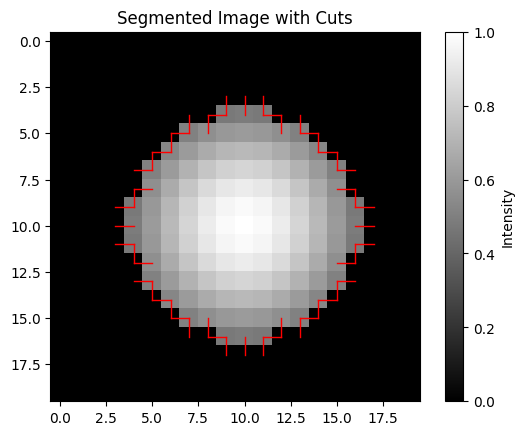

In [21]:
main('oval.csv',0,0,10,10,0.07)

In [15]:
# main('box.csv',0,0,10,10,0.05)
